In [46]:
## -- IMPORTS --
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from dataset_util import BirdDataset
from torch.utils.data import DataLoader
from dataset_util import train_val_loaders, train_val_loaders_with_attributes
from models import create_model


In [47]:
# from google.colab import files
# uploaded = files.upload()


In [48]:
import zipfile
import os

file_name = "train_images.zip"  # change to your filename

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()


In [49]:
# load and clean paths
train_df = pd.read_csv("train_images.csv")

train_df["image_path"] = train_df["image_path"].str.lstrip("/")
train_df["image_path"] = train_df["image_path"].apply(lambda x: "train_images/" + x)
train_df["label_idx"] = train_df["label"] - 1

train_df.head()

,image_path,label,label_idx
0,train_images/train_images/1.jpg,1,0
1,train_images/train_images/2.jpg,1,0
2,train_images/train_images/3.jpg,1,0
3,train_images/train_images/4.jpg,1,0
4,train_images/train_images/5.jpg,1,0


In [50]:
attributes = np.load("attributes.npy", allow_pickle=True)

In [51]:
# class distribution
num_classes = train_df["label_idx"].nunique()
print("Number of images:", len(train_df))
print("Number of classes:", num_classes)

train_df["label"].value_counts().head()

Number of images: 3926
Number of classes: 200


,count
label,
1,35
2,35
4,35
9,34
10,34


In [52]:
# # see one bird
# row0 = train_df.iloc[0]
# img = Image.open(row0["image_path"]).convert("RGB")
# plt.imshow(img)
# plt.title(f"Label: {row0['label']} (idx {row0['label_idx']})")
# plt.axis("off")
# plt.show()

In [53]:
batch_size = 64

train_loader, val_loader, train_df_split, val_df_split = train_val_loaders(
    train_df,
    img_size=(224, 224),
    batch_size=batch_size,
    val_size=0.2,
    random_state=42,
    num_workers=2,
    use_imagenet_norm=True,
    augment=True)

# for the multi task model:
train_loader, val_loader, train_df_split, val_df_split = train_val_loaders_with_attributes(
    train_df,
    attributes=attributes,
    img_size=(224, 224),
    batch_size=batch_size,
    val_size=0.2,
    random_state=42,
    num_workers=2,
    use_imagenet_norm=True,
    augment=True)


### Pipeline start

In [54]:
# Hyperparameters (placeholders)
embedding_dim = 128
lr = 1e-3
epochs = 25

In [55]:
# Model (placeholders)
from embedder_models import BirdEmbeddingModel
from multi_task_models import BirdMultiTaskModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_name = "bird_embedding"
model_name = "multi_task_cnn"

model = create_model(
    model_name=model_name,
    n_classes=200,
    n_attributes=attributes.shape[1],
    feature_dim=256)

model = model.to(device)
print("Using model:", model_name, "on", device)

Using model: multi_task_cnn on cuda


In [56]:
# # Training
# for epoch in range(epochs):
#     model.train()

#     running_loss = 0.0
#     running_correct = 0
#     running_total = 0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         # forward pass
#         logits = model(images)
#         loss = criterion(logits, labels)

#         # backward pass
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * images.size(0)
#         preds = logits.argmax(dim=1)
#         running_correct += (preds == labels).sum().item()
#         running_total += labels.size(0)

#     epoch_loss = running_loss / running_total
#     epoch_acc = running_correct / running_total

#     print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f}")

#     # continue code...

In [57]:
# Hyperparameters for multi-task
lr = 1e-3
epochs = 80
lambda_attr = 1.0
best_val_acc = 0.0

train_losses = []
val_losses = []
train_class_losses = []
val_class_losses = []
train_attr_losses = []
val_attr_losses = []
train_accs = []
val_accs = []

criterion_class = nn.CrossEntropyLoss()
criterion_attr  = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# TRAINING
for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_class_loss = 0.0
    running_attr_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels, attr_vecs in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        attr_vecs = attr_vecs.to(device)

        optimizer.zero_grad()

        # forward pass: returns two things
        class_logits, attr_logits = model(images)

        # main task: class prediction
        loss_class = criterion_class(class_logits, labels)

        # auxiliary task: attribute prediction
        loss_attr = criterion_attr(attr_logits, attr_vecs)

        # total loss
        loss = loss_class + lambda_attr * loss_attr

        # backward pass
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item() * images.size(0)
        running_class_loss += loss_class.item() * images.size(0)
        running_attr_loss += loss_attr.item() * images.size(0)

        preds = class_logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_class_loss = running_class_loss / running_total
    epoch_attr_loss = running_attr_loss / running_total
    epoch_acc = running_correct / running_total

# VALIDATION
    model.eval()

    val_loss = 0.0
    val_class_loss = 0.0
    val_attr_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels, attr_vecs in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            attr_vecs = attr_vecs.to(device)

            class_logits, attr_logits = model(images)

            loss_class = criterion_class(class_logits, labels)
            loss_attr  = criterion_attr(attr_logits, attr_vecs)
            loss = loss_class + lambda_attr * loss_attr

            val_loss += loss.item() * images.size(0)
            val_class_loss += loss_class.item() * images.size(0)
            val_attr_loss += loss_attr.item() * images.size(0)

            preds = class_logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_class_loss = val_class_loss / val_total
    epoch_val_attr_loss = val_attr_loss / val_total
    epoch_val_acc = val_correct / val_total

    # save best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_multitask_model.pth")

    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    train_class_losses.append(epoch_class_loss)
    val_class_losses.append(epoch_val_class_loss)
    train_attr_losses.append(epoch_attr_loss)
    val_attr_losses.append(epoch_val_attr_loss)
    train_accs.append(epoch_acc)
    val_accs.append(epoch_val_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"- Train Loss: {epoch_loss:.4f} (cls {epoch_class_loss:.4f}, attr {epoch_attr_loss:.4f}) "
        f"- Train Acc: {epoch_acc:.4f} "
        f"- Val Loss: {epoch_val_loss:.4f} (cls {epoch_val_class_loss:.4f}, attr {epoch_val_attr_loss:.4f}) "
        f"- Val Acc: {epoch_val_acc:.4f}")

print(f"Best Val Acc: {best_val_acc:.4f}")

Epoch [1/80] - Train Loss: 5.6363 (cls 5.3283, attr 0.3080) - Train Acc: 0.0073 - Val Loss: 5.3899 (cls 5.2107, attr 0.1792) - Val Acc: 0.0051
Epoch [2/80] - Train Loss: 5.3827 (cls 5.2469, attr 0.1359) - Train Acc: 0.0057 - Val Loss: 5.3117 (cls 5.1836, attr 0.1281) - Val Acc: 0.0153
Epoch [3/80] - Train Loss: 5.3220 (cls 5.1974, attr 0.1246) - Train Acc: 0.0080 - Val Loss: 5.2149 (cls 5.0961, attr 0.1187) - Val Acc: 0.0191
Epoch [4/80] - Train Loss: 5.2365 (cls 5.1159, attr 0.1206) - Train Acc: 0.0156 - Val Loss: 5.1986 (cls 5.0786, attr 0.1201) - Val Acc: 0.0153
Epoch [5/80] - Train Loss: 5.1923 (cls 5.0741, attr 0.1183) - Train Acc: 0.0115 - Val Loss: 5.1406 (cls 5.0274, attr 0.1132) - Val Acc: 0.0191
Epoch [6/80] - Train Loss: 5.1628 (cls 5.0453, attr 0.1175) - Train Acc: 0.0131 - Val Loss: 5.1236 (cls 5.0068, attr 0.1169) - Val Acc: 0.0178
Epoch [7/80] - Train Loss: 5.1340 (cls 5.0171, attr 0.1169) - Train Acc: 0.0159 - Val Loss: 5.1120 (cls 4.9972, attr 0.1147) - Val Acc: 0.0165

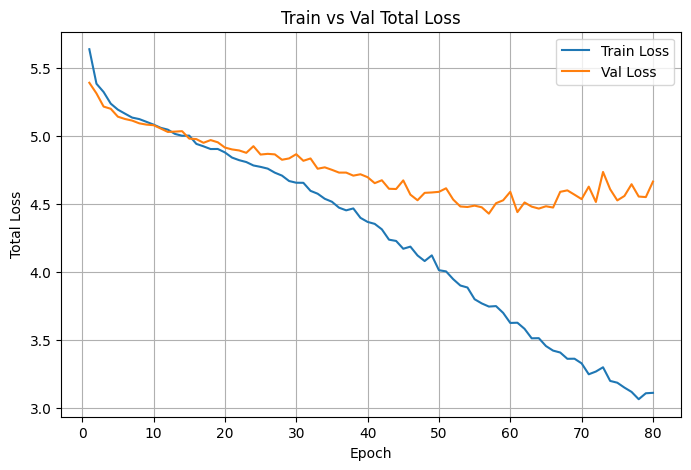

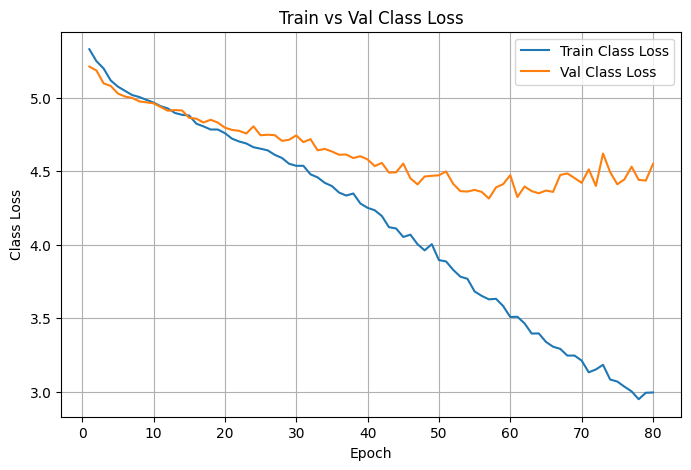

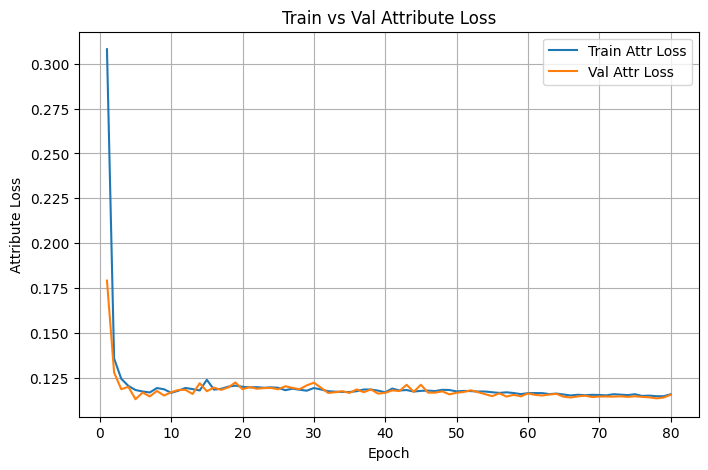

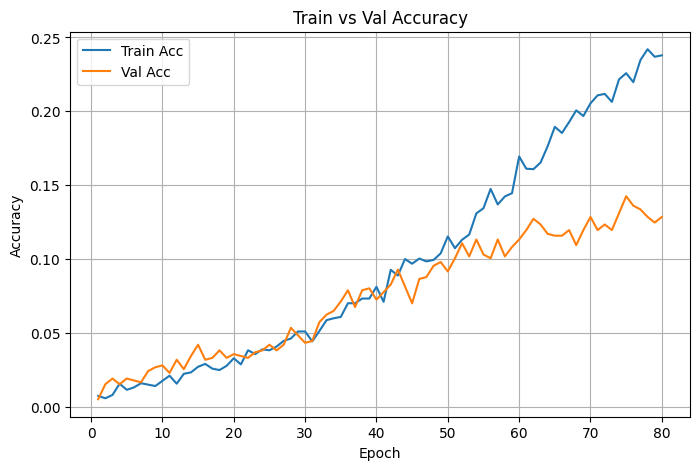

In [58]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# Total loss curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Train vs Val Total Loss")
plt.legend()
plt.grid(True)
plt.show()

# Class loss curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_class_losses, label="Train Class Loss")
plt.plot(epochs_range, val_class_losses, label="Val Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Class Loss")
plt.title("Train vs Val Class Loss")
plt.legend()
plt.grid(True)
plt.show()

# Attribute loss curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_attr_losses, label="Train Attr Loss")
plt.plot(epochs_range, val_attr_losses, label="Val Attr Loss")
plt.xlabel("Epoch")
plt.ylabel("Attribute Loss")
plt.title("Train vs Val Attribute Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curve
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# from google.colab import files
# uploaded = files.upload()

In [60]:
import zipfile
import os

file_name = "test_images.zip"

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()


In [61]:
from tqdm import tqdm

model.load_state_dict(torch.load("best_multitask_model.pth", map_location=device))
model.eval()

# Load test paths
test_df = pd.read_csv("test_images_path.csv")

# Fix path formatting if needed
test_df["image_path"] = test_df["image_path"].str.lstrip("/")
test_df["image_path"] = "test_images/" + test_df["image_path"]

# Use same transform as validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

predictions = []

for img_path in tqdm(test_df["image_path"]):
    img = Image.open(img_path).convert("RGB")
    img = val_transform(img)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        if isinstance(outputs, tuple):       # Multi-task model
            class_logits, _ = outputs
        else:                                # Single-task model
            class_logits = outputs

        pred = class_logits.argmax(dim=1).item()

    # convert 0-199 back to 1-200 labels
    pred += 1
    predictions.append(pred)

test_df["label"] = predictions

# Keep only required columns in correct order
submission = test_df[["id", "label"]]

# Save final submission
submission.to_csv("submission.csv", index=False)

print("Done! Saved as submission.csv")
submission.head()


100%|██████████| 4000/4000 [00:24<00:00, 162.48it/s]

Done! Saved as submission.csv


,id,label
0,1,17
1,2,118
2,3,28
3,4,182
4,5,32
